<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/P2_G30_COMP551.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **COMP 551 - Applied Machine Learning**

### MiniProject 2: Optimization and Text Classification

Takuya Ishii () <br>
Felix Simard (260865674) <br>
Tyler Watson ()

**Group 30** <br>
Oct 21th, 2021


## **Setup**

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import joblib
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize        
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Part 1: Optimization**
Link to datasets: https://github.com/felixsimard/comp551-p2/tree/main/diabetes


## **Part 2: Text Classification**
Link to datasets: https://github.com/felixsimard/comp551-p2/tree/main/fake_news


In [29]:
# Define constants

# Contractions dictonary
# Reference: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')

In [30]:
# Define dataset paths
fake_new_train_dir = r'fake_news/fake_news_train.csv'
fake_news_val_dir = r'fake_news/fake_news_val.csv'
fake_news_test_dir = r'fake_news/fake_news_test.csv'

# Load datasets
fake_news_train = pd.read_csv(fake_new_train_dir, engine="python", error_bad_lines=False)
fake_news_val = pd.read_csv(fake_news_val_dir, engine="python", error_bad_lines=False)
fake_news_test = pd.read_csv(fake_news_test_dir, engine="python", error_bad_lines=False)

fake_news_train

Skipping line 5985: unexpected end of data


,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
5978,White House press secretary Sarah Huckabee San...,1
5979,Organizers of the Plantation Youth Fishing Cli...,0
5980,Share\nMicrosoft this past weekend quietly upd...,1
5981,NDP Leader Rachel Notley says her party’s sign...,1


#### Quick dataset scan

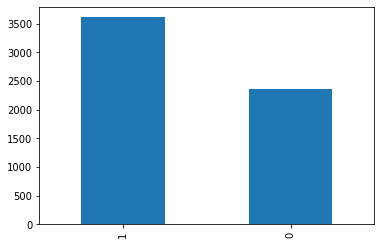

In [31]:
# Look at label value distribution and save ratios for Logitic Regression class weights
train_value_counts = fake_news_train.label.value_counts()
total = train_value_counts[0] + train_value_counts[1]
train_labels_ratio = {
    0: train_value_counts[0] / total,
    1: train_value_counts[1] / total,
}

train_value_counts.plot(kind='bar')

#### Preprocessing

In [32]:
# Stemmer function
def apply_stemmer(text):
    stemmer= PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

# Expanding contractions
# Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Remove stop-words
# Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
# Preprocessing function
def preprocess(df):

    # Lowercase everything
    df['text'] = df['text'].str.lower()

    # Expand contractions
    # Reference: https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
    df['text'] = df['text'].apply(lambda x : expand_contractions(x))

    # Remove ponctuation
    df['text'] = df['text'].replace(r'[^\w\s]', r'', regex=True)

    # Remove numbers
    df['text'] = df['text'].replace(r'\d', r'', regex=True)

    # Remove special characters (eg: \n)
    df['text'] = df['text'].replace(r'\\[a-z]', r'', regex=True)

    # Remove stop words
    df['text'] = df['text'].apply(lambda x : remove_stopwords(x))

    # Stemming - not helping generalization...
    # df["text"] = df["text"].apply(lambda x: apply_stemmer(x))

    # Trim whitespaces
    df['text'] = df['text'].str.strip()

    # Word level count vectorization
    vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=5, max_df=0.5, max_features=20000, binary=True)
    X_train_counts = vect.fit_transform(df.text)
    joblib.dump(vect, "vectorizer.pkl")
    print("Vectorizer vocabulary:", vect.vocabulary_.get(u'algorithm'))
    print("Count Vectorizer shape:", X_train_counts.shape)
    

    # TF-IDF representation using bag-of-words matrix
    tfidf_transform = TfidfTransformer()
    X_train_tfidf = tfidf_transform.fit_transform(X_train_counts)
    joblib.dump(tfidf_transform, "tfidf_transform.pkl")
    print("TF-IDF shape:", X_train_tfidf.shape)
    print("\n")

    return X_train_tfidf, df

# fake_news_train_preprocessed_tfidf, fake_news_train_preprocessed = preprocess(fake_news_train)
# fake_news_train_preprocessed

#### Model Training, Validation, Testing

In [33]:
def train_model(x_train, y_train, params={}):
    # preprocess x_train
    x_train_preprocessed_tfidf, x_train_preprocessed  = preprocess(x_train)

    # fit model
    model = LogisticRegression(C=1, class_weight='balanced', fit_intercept=False, tol=0.001, solver='liblinear', multi_class='ovr')
    trained = model.fit(x_train_preprocessed_tfidf, y_train)
    training_score = trained.score(x_train_preprocessed_tfidf, y_train)
    joblib.dump(trained, "model.pkl")

    print("Training score:", training_score)

    # Grid cross validation
    grid = GridSearchCV(estimator=model, param_grid=params)
    grid.fit(x_train_preprocessed_tfidf, y_train)
    print(grid)
    print(grid.best_score_)
    print(grid.best_estimator_)

    return trained

def transform_preprocess(x_test):
    # Load saved pickles
    loaded_vectorizer = joblib.load("vectorizer.pkl")
    loaded_tfidf_transform = joblib.load("tfidf_transform.pkl")
    loaded_model = joblib.load("model.pkl")

    # Transform
    x_val_vec = loaded_vectorizer.transform(x_test)
    x_val_tfidf = loaded_tfidf_transform.transform(x_val_vec)

    return x_val_tfidf


In [34]:
# Grid search parameters for cross validation
param_grid = [
          {'C': [1, 5, 10], 'solver': ['newton-cg', 'liblinear', 'lbfgs'], 'tol': [0.0001, 0.001, 0.01, 0.1], 'max_iter': [100, 200]}
]

In [35]:
# Train model
trained_model = train_model(fake_news_train, fake_news_train['label'], params=param_grid)

Vectorizer vocabulary: 537
Count Vectorizer shape: (5983, 20000)
TF-IDF shape: (5983, 20000)


Training score: 0.9421694801938827
GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1, class_weight='balanced',
                                          dual=False, fit_intercept=False,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 5, 10], 'max_iter': [100, 200],
                          'solver': ['newton-cg', 'liblinear', 'lbfgs'],
                          'tol': [0.0001, 0.001, 0.01, 0.1]}],
         

In [36]:

# Test set
x_test_tfidf = transform_preprocess(fake_news_test['text'])
y_predictions = trained_model.predict(x_test_tfidf)

acc_score = accuracy_score(fake_news_test['label'], y_predictions)
print("Accuracy on test set:", acc_score)

Accuracy on test set: 0.6883333333333334
